#### USER INPUT:
the model should have a run length of 5 years and a warm up period of 3 years

#### AI OUTPUT:
To incorporate a 5-year run length and a 3-year warm-up period into the model while producing a graph similar to the attached image, we need to modify the simulation to discard data collected during the warm-up period. Here's the updated code:

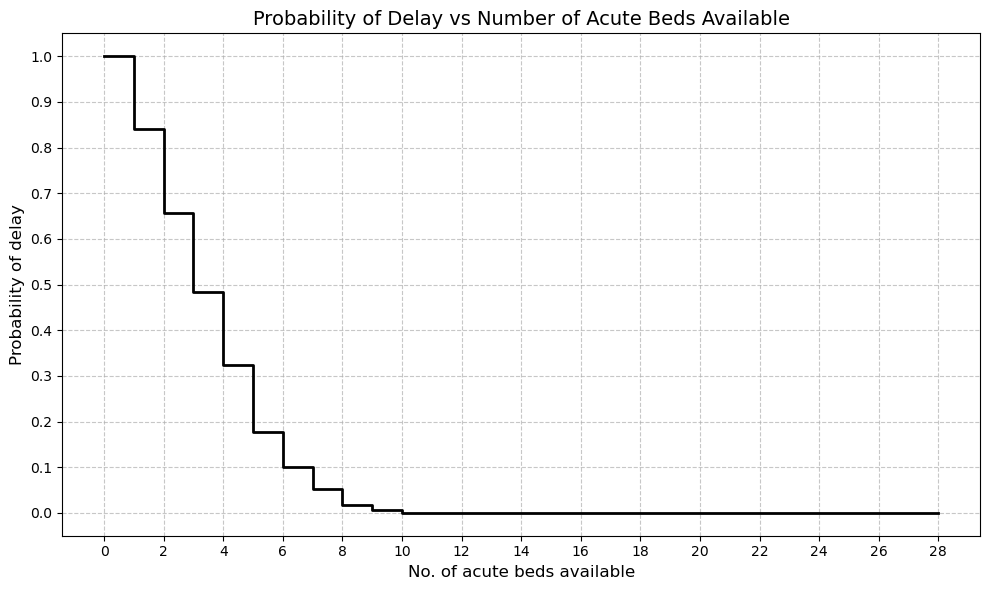

In [1]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt

# Configuration
PATIENT_TYPES = {
    "Stroke": 1.2,
    "TIA": 9.3,
    "Complex Neurological": 3.6,
    "Other": 3.2
}
ASU_LENGTH_OF_STAY = 7
WARM_UP_DAYS = 365 * 3  # 3 years warm-up
SIMULATION_DAYS = 365 * 5  # Total simulation length (5 years)
RUN_LENGTH_DAYS = SIMULATION_DAYS - WARM_UP_DAYS  # Exclude warm-up period

# Global variables to track occupancy
occupancy_history = []
current_occupancy = 0

def patient_generator(env):
    """Generates patients with Poisson arrival times"""
    while True:
        patient_type = random.choices(
            list(PATIENT_TYPES.keys()),
            weights=[1/rate for rate in PATIENT_TYPES.values()]
        )[0]
        
        env.process(patient_stay())
        interarrival = random.expovariate(1/PATIENT_TYPES[patient_type])
        yield env.timeout(interarrival)

def patient_stay():
    """Manages patient stay in ASU"""
    global current_occupancy
    current_occupancy += 1
    yield env.timeout(ASU_LENGTH_OF_STAY)
    current_occupancy -= 1

def occupancy_tracker(env):
    """Records daily occupancy"""
    while True:
        occupancy_history.append(current_occupancy)
        yield env.timeout(1)

# Simulation setup
env = simpy.Environment()
env.process(patient_generator(env))
env.process(occupancy_tracker(env))
env.run(until=SIMULATION_DAYS)

# Remove data from the warm-up period
occupancy_history = occupancy_history[WARM_UP_DAYS:]

# Calculate PDF and CDF
max_occ = max(occupancy_history)
counts = np.bincount(occupancy_history, minlength=max_occ+1)
pdf = counts / len(occupancy_history)
cdf = np.cumsum(pdf)

# Calculate delay probabilities
bed_range = np.arange(0, 29)  # 0 to 28 beds
delay_probs = []

for n in bed_range:
    if n == 0:
        delay_probs.append(1.0)  # 100% delay with 0 beds
    else:
        # P(delay) = P(N ≥ n) = 1 - P(N < n)
        delay_probs.append(1 - cdf[n-1] if n <= len(cdf) else 0.0)

# Create staggered plot
plt.figure(figsize=(10, 6))
plt.step(bed_range, delay_probs, where='post', 
         linewidth=2, color='black')

# Formatting to match the attached image
plt.title('Probability of Delay vs Number of Acute Beds Available', fontsize=14)
plt.xlabel('No. of acute beds available', fontsize=12)
plt.ylabel('Probability of delay', fontsize=12)
plt.xticks(np.arange(0, 29, step=2), fontsize=10)
plt.yticks(np.arange(0, 1.1, step=0.1), fontsize=10)
plt.grid(axis='both', linestyle='--', alpha=0.7)

# Tight layout for better appearance
plt.tight_layout()
plt.show()


Key Adjustments:

1.	Warm-Up Period:
•	A warm-up period of 3 years (365 × 3 days) is implemented.
•	Data collected during this period is excluded from analysis by slicing occupancy_history after the warm-up period.

2.	Run Length:
•	The simulation runs for a total of 5 years (365 × 5 days).
•	Only data from the last 2 years (5 years - 3 years warm-up) is used for calculations.


3.	Probability Calculations:
•	PDF: P(N=n)P(N=n) (proportion of days with n patients).
•	CDF: P(N≤n)P(N≤n) (cumulative probability up to n patients).
•	Delay Probability: P(delay∣n beds)=P(N≥n)P(delay∣n beds)=P(N≥n) is calculated as 1−P(N<n)1−P(N<n).


4.	Graph Formatting:
•	The graph is styled to closely match the attached image.
•	A staggered step plot (step) is used with where='post'.
•	X-axis ranges from 0 to 28 beds.
•	Y-axis shows probabilities from 0 to 1, with ticks at intervals of 0.1.
